ROC_curve是评价二分类器的一种有效方式
本示例通过Titanic数据集的分析来进行演示

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [30]:
data = pd.read_csv("./rsc_data/titanic_train.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
# 缺失值处理
df = pd.concat([data.isnull().sum()], axis=1, keys=["Null_num"])
# 同 df = pd.DataFrame(data.isnull().sum(), columns=["Null_num"])
df[df.sum(axis=1)>0]

,Null_num
Age,177
Cabin,687
Embarked,2


In [22]:
# 数据类型
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [31]:
# 删除Name、Ticket、Cabin等非结构化或者无关数据
data.drop(["Name", "Ticket", "Cabin", "PassengerId"], axis=1, inplace=True)

# Age缺失值用均值填充
data["Age"].fillna(data["Age"].mean(), inplace=True)

# Embarked缺失值用
data["Embarked"].fillna(data["Embarked"].mode()[0], inplace=True)

# Pclass应当为类别，无数值意义，所以用str格式代替
data["Pclass"] = data["Pclass"].apply(str)

# 对于其他的类别类特征，进行one-hot编码
for col in data.select_dtypes("object").columns:
    for_dummpy = data.pop(col)
    data = pd.concat([data, pd.get_dummies(for_dummpy,prefix=col)], axis=1)

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
Survived      891 non-null int64
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Pclass_1      891 non-null uint8
Pclass_2      891 non-null uint8
Pclass_3      891 non-null uint8
Sex_female    891 non-null uint8
Sex_male      891 non-null uint8
Embarked_C    891 non-null uint8
Embarked_Q    891 non-null uint8
Embarked_S    891 non-null uint8
dtypes: float64(2), int64(3), uint8(8)
memory usage: 41.8 KB


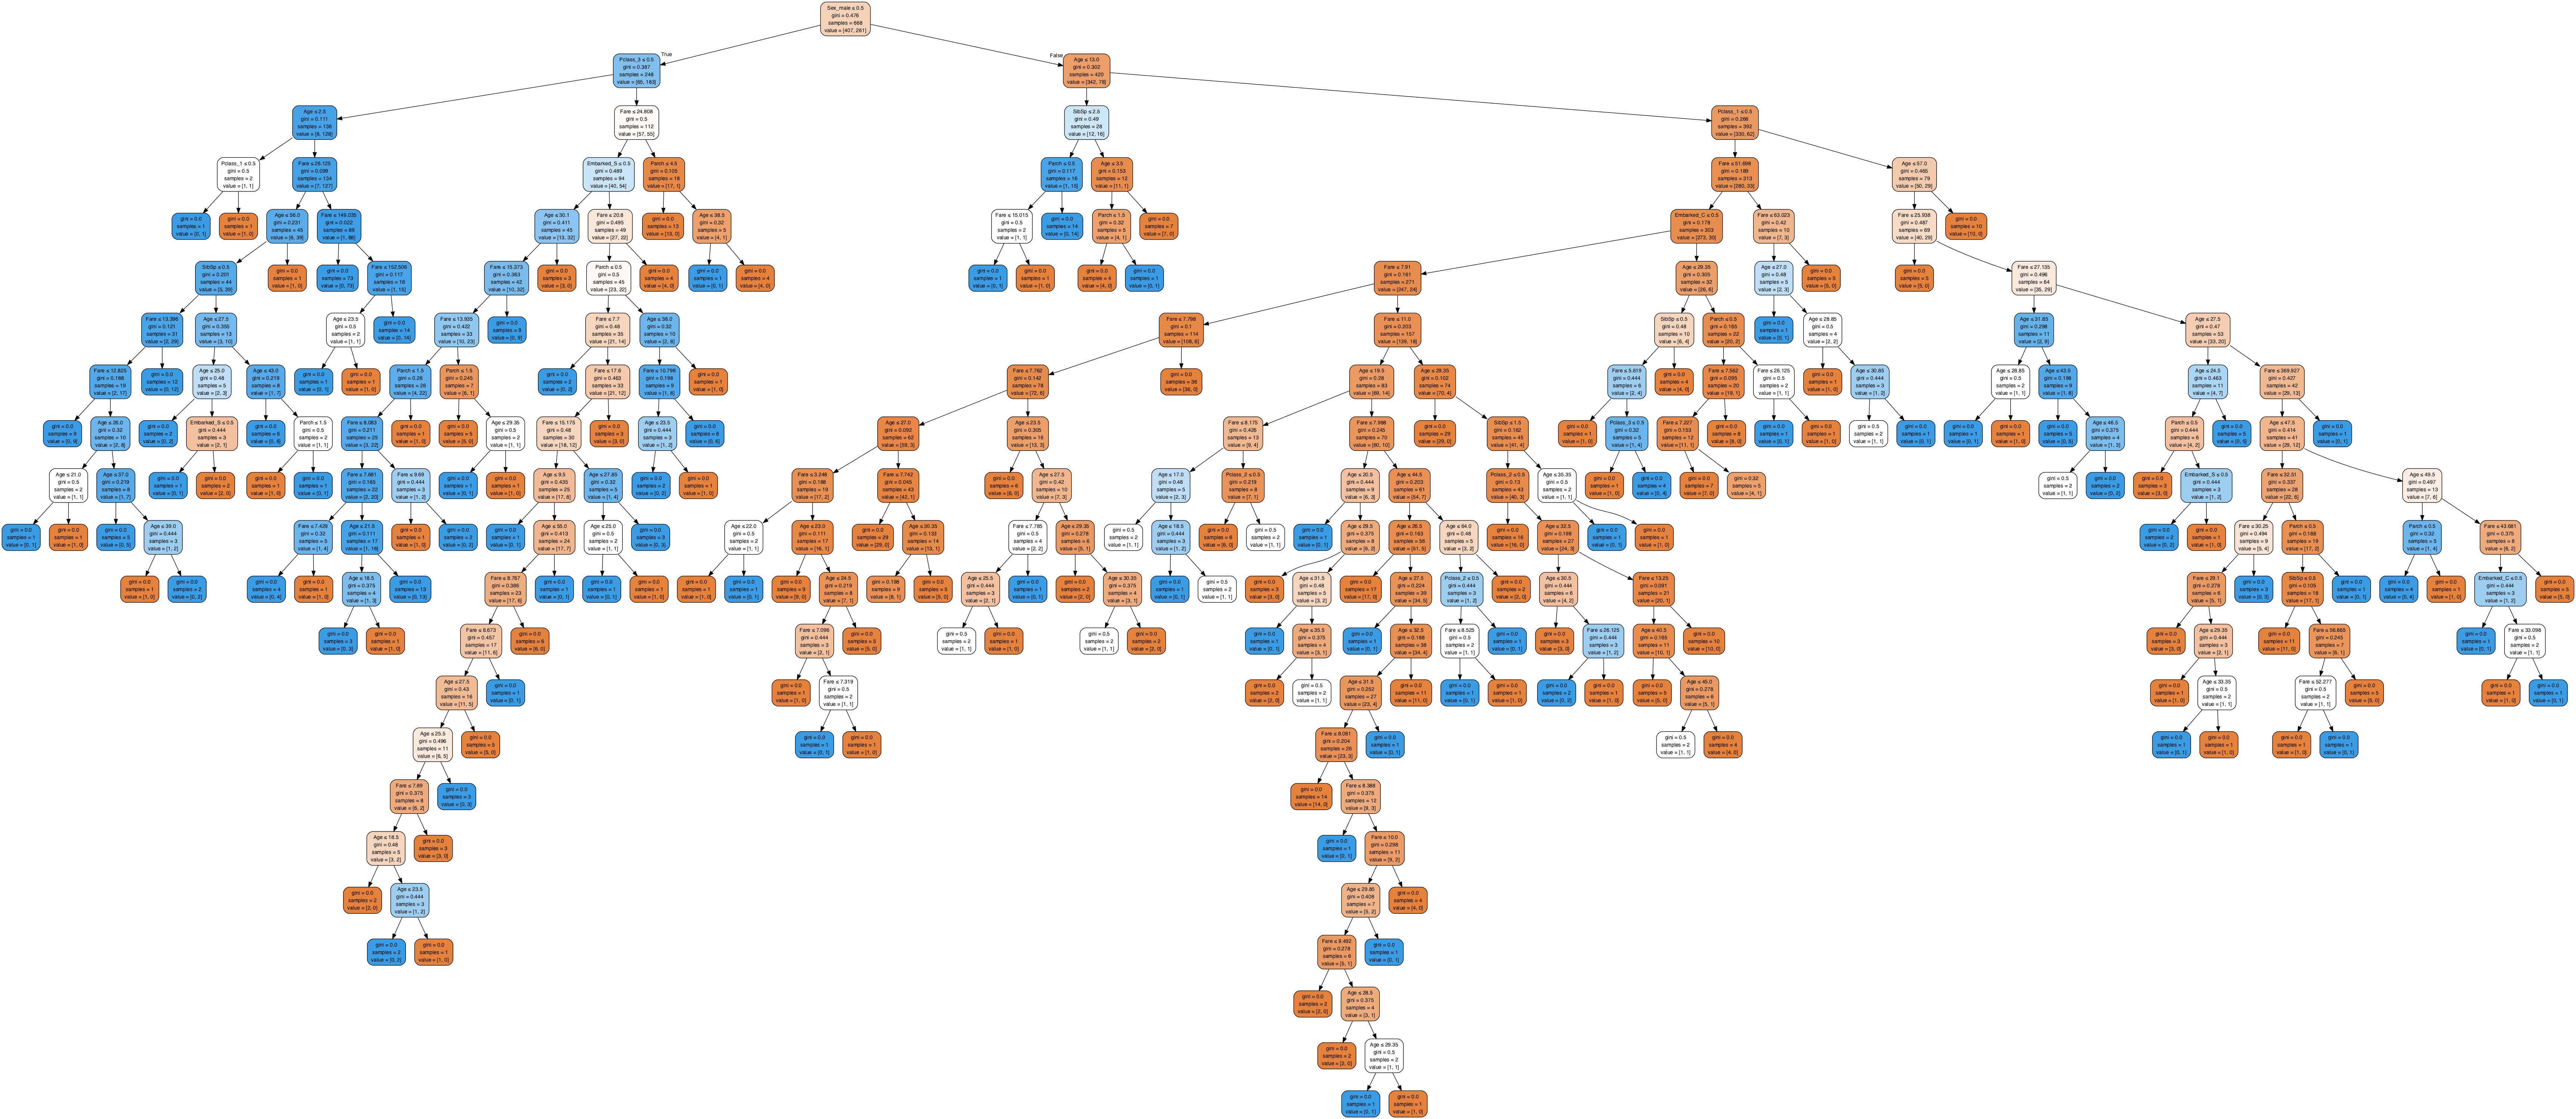

In [40]:
# 采用默认参数建立模型
labels = data.pop("Survived")
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.25)
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

from sklearn import tree
import pydotplus
from IPython.display import Image
dot_data = tree.export_graphviz(dt, out_file=None,
                         feature_names=data.columns,
                         filled=True, rounded=True,
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

绘制ROC曲线

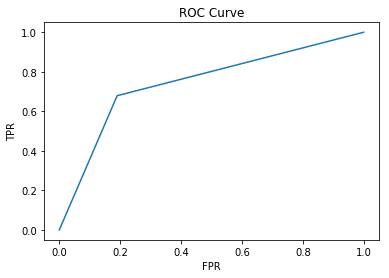

In [53]:
y_pred = dt.predict(x_test)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

通过AUC作为衡量学习器的指标进行调参数

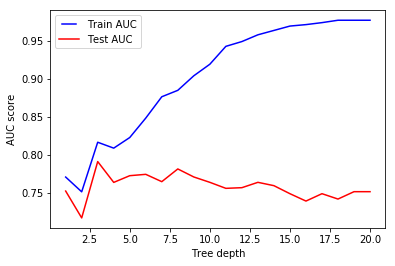

In [54]:
# 调整DecisionTreeClassifier的max_depth参数
from sklearn.metrics import auc

max_depths = np.linspace(1, 20, 20, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(x_train, y_train)
    fpr_train, tpr_train, threshold_train = roc_curve(y_train, dt.predict(x_train))    
    roc_auc_train = auc(fpr_train, tpr_train)
    train_results.append(roc_auc_train)
    
    fpr_test, tpr_test, threshold_test = roc_curve(y_test, dt.predict(x_test))  
    roc_auc_test = auc(fpr_test, tpr_test)
    test_results.append(roc_auc_test)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

同理，可以对其他参数进行调参。